Создание и подготовка датасета.

In [1]:
import pandas as pd

url = "https://seafiles.dtwin.ru/f/2747c14e1ee5420b9241/?dl=1"
df = pd.read_csv(url, sep=';')

df.head()

null_fact_df = df[df['fact'].isnull()]

df_cleaned = df[~df.index.isin(null_fact_df.duplicated(subset=['Город', 'year'], keep='first').index)]

df_cleaned['погрешность'] = ((df_cleaned['Модель'] - df_cleaned['fact']) / df_cleaned['fact']) * 100


duplicate_count = df_cleaned.duplicated(subset=['Город', 'year'], keep='first').sum()

df_cleaned = df_cleaned.drop_duplicates(subset=['Город', 'year'], keep='first')

C:\Users\rostislav\AppData\Local\Temp\ipykernel_23028\3765722430.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['погрешность'] = ((df_cleaned['Модель'] - df_cleaned['fact']) / df_cleaned['fact']) * 100


Анализ данных и построение графиков и диаграмм.

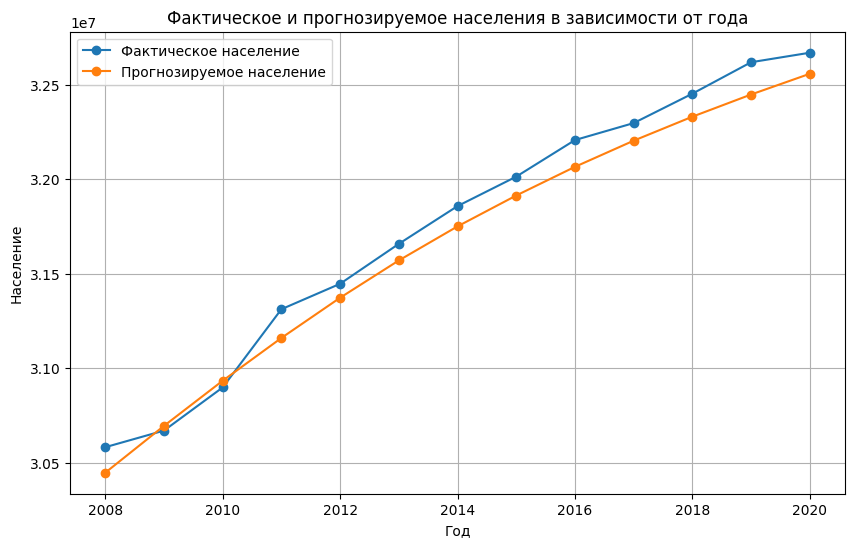

C:\Users\rostislav\AppData\Local\Temp\ipykernel_23028\3055754048.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_change = df_cleaned.groupby('year').apply(


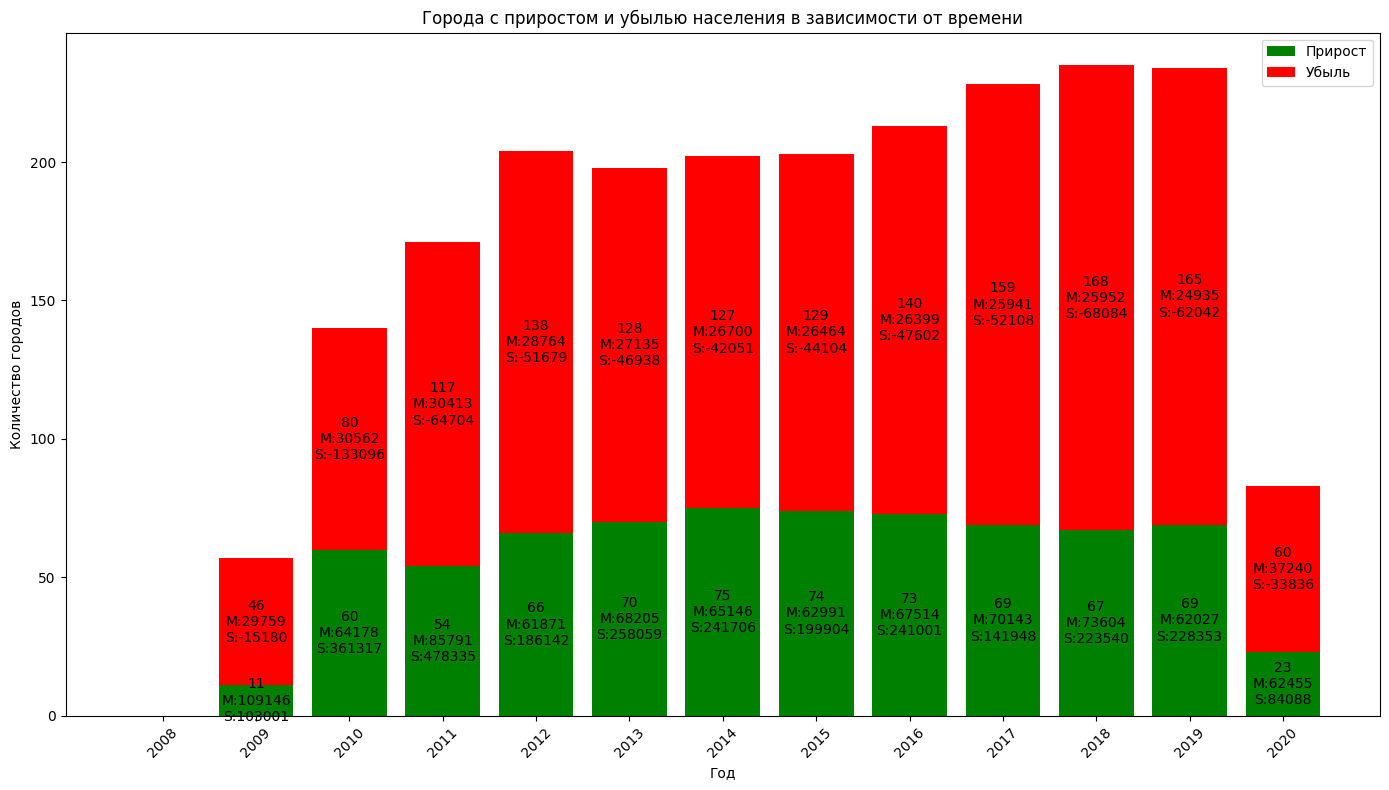

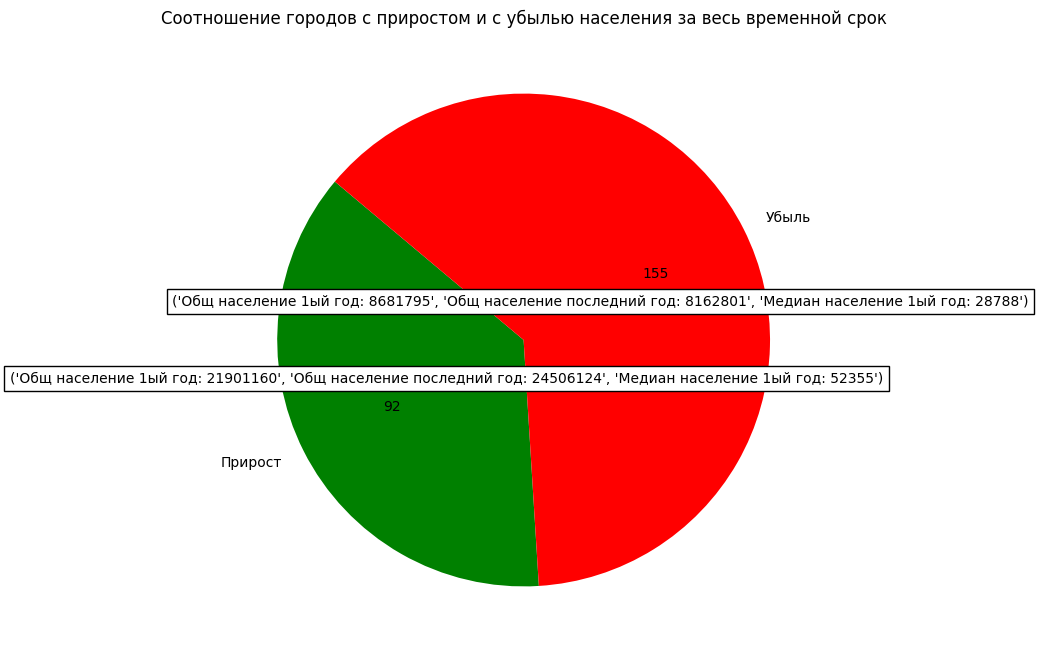

Количество городов с постоянным ростом на всём временном промежутке: 35
Количество городов с постоянной убылью на всём временном промежутке: 96
Медианное население городов с постоянным ростом: 65248.0
Медианное население городов с постоянной убылью: 26336.5


In [2]:
import matplotlib.pyplot as plt

yearly_actual_population = df_cleaned.groupby('year')['fact'].sum()
yearly_predicted_population = df_cleaned.groupby('year')['Модель'].sum()

plt.figure(figsize=(10, 6))
plt.plot(yearly_actual_population.index, yearly_actual_population.values, marker='o', linestyle='-', label='Фактическое население')
plt.plot(yearly_predicted_population.index, yearly_predicted_population.values, marker='o', linestyle='-', label='Прогнозируемое население')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Фактическое и прогнозируемое населения в зависимости от года')
plt.legend()
plt.grid(True)
plt.show()






df_cleaned['previous_year_fact'] = df_cleaned.groupby('Город')['fact'].shift(1)
df_cleaned['population_change'] = df_cleaned['fact'] - df_cleaned['previous_year_fact']

yearly_change = df_cleaned.groupby('year').apply(
    lambda x: pd.Series({
        'increase_count': (x['population_change'] > 0).sum(),
        'decrease_count': (x['population_change'] < 0).sum(),
        'increase_median': x.loc[x['population_change'] > 0, 'fact'].median(),
        'decrease_median': x.loc[x['population_change'] < 0, 'fact'].median(),
        'increase_sum': x.loc[x['population_change'] > 0, 'population_change'].sum(),
        'decrease_sum': x.loc[x['population_change'] < 0, 'population_change'].sum()
    })
).reset_index()

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.8
bars_increase = ax.bar(yearly_change['year'], yearly_change['increase_count'], color='green', label='Прирост')
bars_decrease = ax.bar(yearly_change['year'], yearly_change['decrease_count'], bottom=yearly_change['increase_count'], color='red', label='Убыль')

for i, bar in enumerate(bars_increase):
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height / 2, 
            f'{int(height)}\nM:{int(yearly_change.loc[i, "increase_median"])}\nS:{int(yearly_change.loc[i, "increase_sum"])}', 
            ha='center', 
            va='center', 
            color='black'
        )

for i, bar in enumerate(bars_decrease):
    height = bar.get_height()
    total_height = bar.get_y() + height
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            total_height - height / 2, 
            f'{int(height)}\nM:{int(yearly_change.loc[i, "decrease_median"])}\nS:{int(yearly_change.loc[i, "decrease_sum"])}', 
            ha='center', 
            va='center', 
            color='black'
        )

ax.set_xlabel('Год')
ax.set_ylabel('Количество городов')
ax.set_title('Города с приростом и убылью населения в зависимости от времени')
ax.legend()

plt.xticks(yearly_change['year'], rotation=45)
plt.tight_layout()

plt.show()






import numpy as np

city_first_last = df_cleaned.groupby('Город').agg({'year': ['min', 'max'], 'fact': ['first', 'last']})
city_first_last.columns = ['year_min', 'year_max', 'fact_first', 'fact_last']

city_first_last['population_change'] = city_first_last['fact_last'] - city_first_last['fact_first']
city_first_last['increase'] = city_first_last['population_change'] > 0
city_first_last['decrease'] = city_first_last['population_change'] < 0

increase_count = city_first_last['increase'].sum()
decrease_count = city_first_last['decrease'].sum()

sizes = [increase_count, decrease_count]
labels = ['Прирост', 'Убыль']
colors = ['green', 'red']

sum_increase_first_year = city_first_last[city_first_last['increase']]['fact_first'].sum()
sum_decrease_first_year = city_first_last[city_first_last['decrease']]['fact_first'].sum()
sum_increase_last_year = city_first_last[city_first_last['increase']]['fact_last'].sum()
sum_decrease_last_year = city_first_last[city_first_last['decrease']]['fact_last'].sum()

median_increase_first_year = city_first_last[city_first_last['increase']]['fact_first'].median()
median_decrease_first_year = city_first_last[city_first_last['decrease']]['fact_first'].median()

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, colors=colors, autopct=lambda p: f'{int(p * sum(sizes) / 100)}', startangle=140)

for i, wedge in enumerate(wedges):
    if labels[i] == 'Прирост':
        sum_first_text = f'Общ население 1ый год: {int(sum_increase_first_year)}'
        sum_last_text = f'Общ население последний год: {int(sum_increase_last_year)}'
        median_first_text = f'Медиан население 1ый год: {int(median_increase_first_year)}'
    elif labels[i] == 'Убыль':
        sum_first_text = f'Общ население 1ый год: {int(sum_decrease_first_year)}'
        sum_last_text = f'Общ население последний год: {int(sum_decrease_last_year)}'
        median_first_text = f'Медиан население 1ый год: {int(median_decrease_first_year)}'
    
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = wedge.r * 0.7 * 0.5 * np.cos(np.radians(angle))
    y = wedge.r * 0.7 * 0.5 * np.sin(np.radians(angle))
    
    ax.text(x, y, (sum_first_text, sum_last_text, median_first_text), ha='center', va='center', fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ax.set_title('Соотношение городов с приростом и с убылью населения за весь временной срок')

plt.show()






cities_with_consistent_growth = []
unique_cities = df_cleaned['Город'].unique()

for city in unique_cities:
    city_data = df_cleaned[df_cleaned['Город'] == city]
    if city_data['fact'].is_monotonic_increasing:
        cities_with_consistent_growth.append(city)

cities_with_consistent_decrease = []
unique_cities = df_cleaned['Город'].unique()

for city in unique_cities:
    city_data = df_cleaned[df_cleaned['Город'] == city]
    if city_data['fact'].is_monotonic_decreasing:
        cities_with_consistent_decrease.append(city)

print(f'Количество городов с постоянным ростом на всём временном промежутке: {len(cities_with_consistent_growth)}')
print(f'Количество городов с постоянной убылью на всём временном промежутке: {len(cities_with_consistent_decrease)}')

consistent_growth_df = df_cleaned[df_cleaned['Город'].isin(cities_with_consistent_growth)]
earliest_population_growth = consistent_growth_df.loc[consistent_growth_df.groupby('Город')['year'].idxmin()][['Город', 'year', 'fact']]
consistent_decrease_df = df_cleaned[df_cleaned['Город'].isin(cities_with_consistent_decrease)]
earliest_population_decrease = consistent_decrease_df.loc[consistent_decrease_df.groupby('Город')['year'].idxmin()][['Город', 'year', 'fact']]

print(f'Медианное население городов с постоянным ростом: {earliest_population_growth["fact"].median()}')
print(f'Медианное население городов с постоянной убылью: {earliest_population_decrease["fact"].median()}')


ВЫВОДЫ

График 'Фактическое и прогнозируемое населения в зависимости от года' демонстрирует постоянный рост общего населения всех городов. Это означает, что эммиграция и естественная убыль населения компенсируется естественным ростом населения и эммиграцией из неучтённых городов и других стран. Но это уместно только при взгляде на суммарное насселение всех городов.

Прогнозируемые значения суммарной численности населения во всех городах немного ниже фактического значения, но отражают общую тенденцию.

На графике 'Города с приростом и убылью населения в зависимости от времени' для каждого года продемонстрировано количество городов с убылью населения и количество городов с приростом населения. Также известны медианное население(обозначение 'M') и суммарный прирост/суммарная убыль(обозначение 'S').

Убыль наблюдается в основном среди городов с небольшим населением. Прирост же наблюдается в меньшем количестве городов и это города с бОльшим населением, что видно по значениям 'M'. Таким образом, опираясь также на диаграмму 'Соотношение городов с приростом и с убылью населения за весь временной срок' и анализ городов с постоянным ростом и постоянной убылью, можно сказать, что происходит урбанизация - маленькие города становятся меньше, а большие - больше.

Стоит отметить, что общий прирост населения среди городов с растущим населением для каждого года значительно превосходит общую убыль среди городов с убывающим населением. То есть, даже при условии, что все уезжающие из малых городов направляются в города большие, прирост населения в больших городах обусловлен не столько эммиграцией из маленьких городов, сколько естественным ростом населения и эммиграцией из других стран. Это может свидетельствовать о более высоком уровне жизни в крупных городах.

Анализ прогнозируемых значений населения

In [3]:
df_cleaned['погрешность'] = df_cleaned['погрешность'].abs()
print(f'Статистическая информация по погрешности прогнозируемой численности для всех городов и всех годов:\n{df_cleaned["погрешность"].describe()}\n')

average_error_by_city = df_cleaned.groupby('Город')['погрешность'].mean()
sorted_cities_by_error = average_error_by_city.sort_values(ascending=False)
top_10_cities = sorted_cities_by_error.head(10)

print(f'ТОП-10 городов с найбольшей средней погрешностью прогнозируемого населения за всё время:\n{top_10_cities}\n')

Статистическая информация по погрешности прогнозируемой численности для всех городов и всех годов:
count    3224.000000
mean        1.152945
std         2.500248
min         0.000000
25%         0.254604
50%         0.580278
75%         1.243783
max        48.968601
Name: погрешность, dtype: float64

ТОП-10 городов с найбольшей средней погрешностью прогнозируемого населения за всё время:
Город
Гудермес      27.627494
Магас         11.808633
Плес           7.563181
Михайловка     6.153905
Назрань        4.737080
Саяногорск     4.357682
Наволоки       4.317879
Коломна        4.216367
Сортавала      3.154576
Карачаевск     3.128572
Name: погрешность, dtype: float64



In [4]:
max_error_by_city = df_cleaned.groupby('Город')['погрешность'].max()
sorted_cities_by_error = max_error_by_city.sort_values(ascending=False)
top_10_cities = sorted_cities_by_error.head(10)

print(f'ТОП-10 городов с найбольшей погрешностью прогнозируемого населения за всё время:\n{top_10_cities}\n')

ТОП-10 городов с найбольшей погрешностью прогнозируемого населения за всё время:
Город
Гудермес      48.968601
Магас         24.050633
Плес          19.422062
Михайловка    15.092325
Саяногорск    14.799621
Карачаевск    14.572155
Наволоки      13.036959
Агидель       10.473633
Коломна       10.044570
Назрань        9.859301
Name: погрешность, dtype: float64



ВЫВОДЫ

Исходя из статистических характеристик погрешности прогнозируемого населения, в общем и целом прогнозируемые данные верны. Но есть города с всплесками погрешности, которые не влияют на общую картину, но могут заставить задуматься о верности модели для конкретно этих городов.